<a href="https://colab.research.google.com/github/OshanJayawardana/vip-cup/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget "https://www.grip.unina.it/download/vipcup2022/random_operations.py" --no-check-certificate -c -O "random_operations.py"

--2022-08-09 04:53:58--  https://www.grip.unina.it/download/vipcup2022/random_operations.py
Resolving www.grip.unina.it (www.grip.unina.it)... 143.225.28.237
Connecting to www.grip.unina.it (www.grip.unina.it)|143.225.28.237|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3492 (3.4K)
Saving to: ‘random_operations.py’

random_operations.p 100%[===================>]   3.41K  --.-KB/s    in 0s      

2022-08-09 04:53:59 (252 MB/s) - ‘random_operations.py’ saved [3492/3492]



In [ ]:
!pip install clip-by-openai

import numpy as np
import os
import clip
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import figure
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torchvision.datasets import CIFAR100
from random_operations import random_operations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 12.8 MB 58.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.

In [ ]:
clip.available_models()

['RN50', 'ViT-B/32']

In [ ]:
! wget "https://drive.google.com/uc?export=download&confirm=s5vl&id=1BFshZAWQgtYleZxLSfYbz-juJhpQkoGF" -c -O "data.rar"

! unrar x "data.rar"

In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████| 353976522/353976522 [00:05<00:00, 60152872.64it/s]


In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("/content/data/real/000000310192.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(['person','synt']).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  

Label probs: [[0.626  0.3738]]


# Zero-Shot Prediction

In [ ]:
import numpy as np
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
def transform(img):
  img = img.resize((224, 224))
  img = np.array(img) / 255.

  assert img.shape == (224, 224, 3)

  # normalize by ImageNet mean and std
  img = img - imagenet_mean
  img = img / imagenet_std
  return img

In [ ]:
image_features.size()

torch.Size([1, 512])

Evaluating

In [ ]:
# EXAMPLE USAGE:
# instantiate the dataset and dataloader
import torchvision
data_dir = "/content/data"
dataloader = torchvision.datasets.ImageFolder(data_dir)

In [ ]:
! rm -r /content/data_pro/real*
! rm -r /content/data_pro/synt*

In [ ]:
! mkdir /content/data_pro
! mkdir /content/data_pro/real
! mkdir /content/data_pro/synt

In [ ]:
input_dir = '/content/data/real/'
out_direct = '/content/data_pro/real/'
random_operations(input_dir, out_direct, seed = 45)

Random Operations from  /content/data/real/ to /content/data_pro/real/


100%|██████████| 500/500 [00:07<00:00, 65.04it/s]


In [ ]:
input_dir = '/content/data/synt/'
out_direct = '/content/data_pro/synt/'
random_operations(input_dir, out_direct, seed = 45)

Random Operations from  /content/data/synt/ to /content/data_pro/synt/


100%|██████████| 500/500 [00:04<00:00, 115.98it/s]


In [ ]:
data_dir_pro = "/content/data_pro"
dataloader_pro = torchvision.datasets.ImageFolder(data_dir_pro)

In [ ]:
features_list=[]
for image,label in tqdm(dataloader_pro):
  x = preprocess(image)
  # make it a batch-like
  x = x.unsqueeze(dim=0)
  with torch.no_grad():
      image_features = model.encode_image(x)
      features_list.append(image_features)

  0%|          | 0/1000 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
numpylist = []
cnt = 0
for el in features_list:
  numpylist.append(el.detach().cpu().numpy())
numpy_arr = np.array(numpylist)
numpy_arr = np.reshape(numpy_arr, (numpy_arr.shape[0], numpy_arr.shape[2]))
print(numpy_arr.shape)

(1000, 512)


In [ ]:
y_labels = []
for image, label in dataloader:
  y_labels.append(label)

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(numpy_arr)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


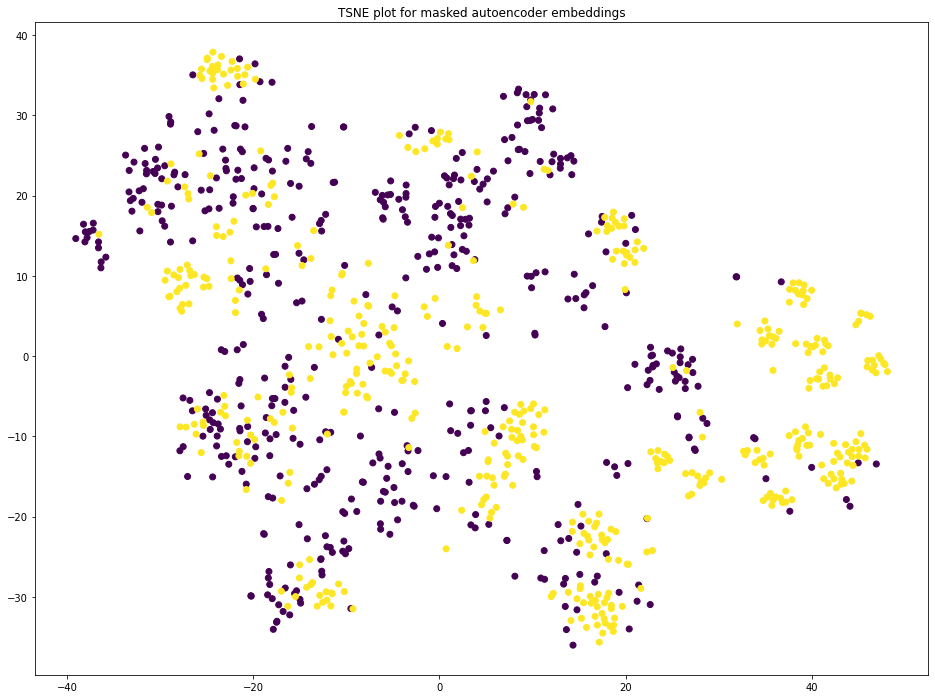

In [ ]:
fig = plt.figure(figsize=(16,12))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_labels)
plt.title("TSNE plot for masked autoencoder embeddings")
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

class NewModel(nn.Module):
            def __init__(self):
                super(NewModel, self).__init__()
                self.linear1 = nn.Linear(512, 256)
                self.linear2 = nn.Linear(256, 64)
                self.linear3 = nn.Linear(64, 1)
            def forward(self, x):
                x = F.relu(self.linear1(x))
                x = F.relu(self.linear2(x))
                x = torch.sigmoid(self.linear3(x))
                return x

new_model = NewModel()
new_model.to(device)

NewModel(
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataloader_pro, [800, 200])

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(new_model.parameters(), lr=0.00001)

from  torch.cuda.amp import autocast
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataset, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = preprocess(inputs)
        inputs = inputs.unsqueeze(dim=0)
        inputs = model.encode_image(inputs)
        labels = torch.tensor([labels]).unsqueeze(1).float()
        outputs = new_model.forward(inputs.float())
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.692
[1,   200] loss: 0.692
[1,   300] loss: 0.693
[1,   400] loss: 0.692
[1,   500] loss: 0.694
[1,   600] loss: 0.691
[1,   700] loss: 0.694
[1,   800] loss: 0.693
[2,   100] loss: 0.692
[2,   200] loss: 0.692
[2,   300] loss: 0.693
[2,   400] loss: 0.692
[2,   500] loss: 0.693
[2,   600] loss: 0.691
[2,   700] loss: 0.694
[2,   800] loss: 0.693
Finished Training


In [ ]:
new_model.eval()
y_pred=[]
y_true=[]
for image,label in tqdm(test_dataset):
  x = preprocess(image)
  # make it a batch-like
  x = x.unsqueeze(dim=0)
  with torch.no_grad():
      image_features = model.encode_image(x)
      output = new_model.forward(image_features.float())
      if output<0.5:
        y_pred.append(0)
      else:
        y_pred.append(1)
      y_true.append(label)

100%|██████████| 200/200 [00:02<00:00, 82.36it/s]


In [ ]:
print(y_true)
print(y_pred)

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,

In [ ]:
correct=0
for i in range(len(y_true)):
  if y_true[i]==y_pred[i]:
    correct+=1
print("Accuracy %: ", (correct/len(y_true))*100)

Accuracy %:  54.50000000000001
